In [19]:
import intake
import numpy as np
import pandas as pd
import xarray as xr
import time
import os

DATA_DIRECTORY = '/oak/stanford/groups/earlew/yuchen'

In [2]:
catalog = intake.open_esm_datastore(
    'https://raw.githubusercontent.com/NCAR/cesm2-le-aws/main/intake-catalogs/aws-cesm2-le.json'
)
catalog.df

,variable,long_name,component,experiment,forcing_variant,frequency,vertical_levels,spatial_domain,units,start_time,end_time,path
0,FLNS,net longwave flux at surface,atm,historical,cmip6,daily,1.0,global,W/m2,1850-01-01 12:00:00,2014-12-31 12:00:00,s3://ncar-cesm2-lens/atm/daily/cesm2LE-histori...
1,FLNSC,clearsky net longwave flux at surface,atm,historical,cmip6,daily,1.0,global,W/m2,1850-01-01 12:00:00,2014-12-31 12:00:00,s3://ncar-cesm2-lens/atm/daily/cesm2LE-histori...
2,FLUT,upwelling longwave flux at top of model,atm,historical,cmip6,daily,1.0,global,W/m2,1850-01-01 12:00:00,2014-12-31 12:00:00,s3://ncar-cesm2-lens/atm/daily/cesm2LE-histori...
3,FSNS,net solar flux at surface,atm,historical,cmip6,daily,1.0,global,W/m2,1850-01-01 12:00:00,2014-12-31 12:00:00,s3://ncar-cesm2-lens/atm/daily/cesm2LE-histori...
4,FSNSC,clearsky net solar flux at surface,atm,historical,cmip6,daily,1.0,global,W/m2,1850-01-01 12:00:00,2014-12-31 12:00:00,s3://ncar-cesm2-lens/atm/daily/cesm2LE-histori...
...,...,...,...,...,...,...,...,...,...,...,...,...
317,WVEL,vertical velocity,ocn,ssp370,smbb,monthly,60.0,global_ocean,centimeter/s,2015-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm2-lens/ocn/monthly/cesm2LE-ssp37...
318,NaN,NaN,ocn,historical,smbb,static,NaN,global_ocean,NaN,NaN,NaN,s3://ncar-cesm2-lens/ocn/static/grid.zarr
319,NaN,NaN,ocn,historical,cmip6,static,NaN,global_ocean,NaN,NaN,NaN,s3://ncar-cesm2-lens/ocn/static/grid.zarr
320,NaN,NaN,ocn,ssp370,smbb,static,NaN,global_ocean,NaN,NaN,NaN,s3://ncar-cesm2-lens/ocn/static/grid.zarr


In [3]:
# list the long names of the variables
catalog.df["long_name"].unique()

array(['net longwave flux at surface',
       'clearsky net longwave flux at surface',
       'upwelling longwave flux at top of model',
       'net solar flux at surface', 'clearsky net solar flux at surface',
       'surface latent heat flux',
       'convective precipitation rate (liq + ice)',
       'large-scale (stable) precipitation rate (liq + ice)',
       'convective snow rate (water equivalent)',
       'large-scale (stable) snow rate (water equivalent)',
       'surface pressure', 'sea level pressure', 'specific humidity',
       'surface sensible heat flux', 'temperature',
       'total (vertically integrated) precipitable water',
       'reference height temperature',
       'minimum reference height temperature over output period',
       'maximum reference height temperature over output period',
       'surface temperature (radiative)', 'zonal wind', 'meridional wind',
       'geopotential height (above sea level)',
       'net solar flux at top of atmosphere',
       'f

In [4]:
# search the catalog and load it as a dataframe
catalog_subset = catalog.search(variable='ICEFRAC', frequency='monthly')
catalog_subset.df

,variable,long_name,component,experiment,forcing_variant,frequency,vertical_levels,spatial_domain,units,start_time,end_time,path
0,ICEFRAC,fraction of sfc area covered by sea-ice,atm,historical,cmip6,monthly,1.0,global,fraction,1850-01-16 12:00:00,2014-12-16 12:00:00,s3://ncar-cesm2-lens/atm/monthly/cesm2LE-histo...
1,ICEFRAC,fraction of sfc area covered by sea-ice,atm,historical,smbb,monthly,1.0,global,fraction,1850-01-16 12:00:00,2014-12-16 12:00:00,s3://ncar-cesm2-lens/atm/monthly/cesm2LE-histo...
2,ICEFRAC,fraction of sfc area covered by sea-ice,atm,ssp370,cmip6,monthly,1.0,global,fraction,2015-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm2-lens/atm/monthly/cesm2LE-ssp37...
3,ICEFRAC,fraction of sfc area covered by sea-ice,atm,ssp370,smbb,monthly,1.0,global,fraction,2015-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm2-lens/atm/monthly/cesm2LE-ssp37...


In [5]:
dsets = catalog_subset.to_dataset_dict(storage_options={'anon':True})


In [6]:
test_retreival = dsets["atm.historical.monthly.cmip6"].isel(member_id=0, time=0).ICEFRAC.load()

In [7]:
test_retreival

<xarray.DataArray 'ICEFRAC' (lat: 192, lon: 288)> Size: 221kB
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.9966427 , 0.9965812 , 0.9965238 , ..., 0.996822  , 0.9967614 ,
        0.9967035 ],
       [0.99736124, 0.9973296 , 0.9972962 , ..., 0.9974618 , 0.9974287 ,
        0.9973945 ],
       [0.99771273, 0.99771106, 0.9977095 , ..., 0.9977187 , 0.99771655,
        0.9977145 ]], dtype=float32)
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
    member_id  <U12 48B 'r10i1181p1f1'
    time       object 8B 1850-01-16 12:00:00
Attributes:
    cell_methods:  time: mean
    long_name:     Fraction of sfc area covered by sea-ice
    units:         fraction

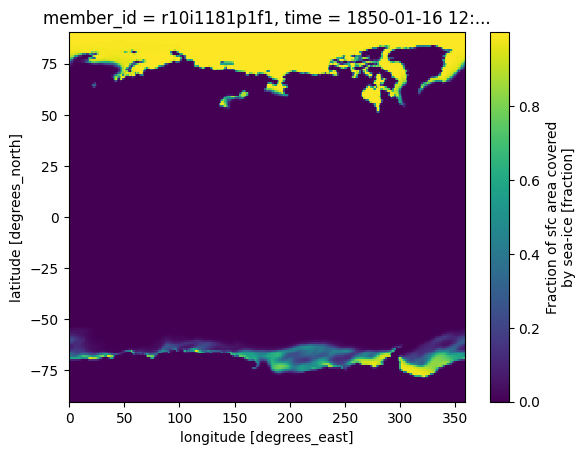

In [8]:
test_retreival.plot()

In [9]:
# let's do a test to see how long it takes to load 120 months (10 yrs)
%time
test_retreival_larger = dsets["atm.historical.monthly.cmip6"].isel(member_id=0, time=slice(0,120)).ICEFRAC.load()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


In [10]:
# let's do a test to see how long it takes to load 1200 months (10 yrs)
%time
test_retreival_larger = dsets["atm.historical.monthly.cmip6"].isel(member_id=0, time=slice(0,1200)).ICEFRAC.load()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.53 µs


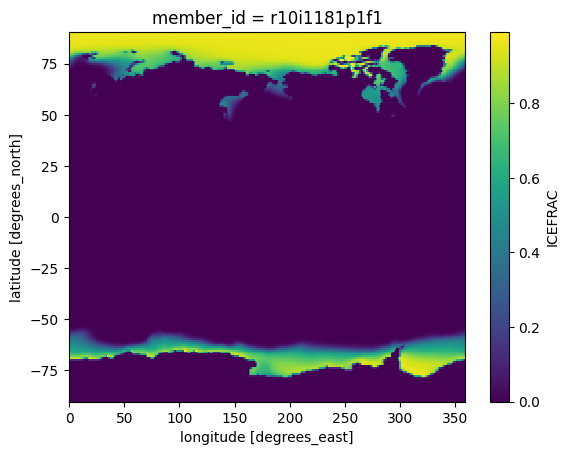

In [11]:
test_retreival_larger.mean("time").plot()

## what about other variables?

In [12]:
variables = catalog.df["variable"]
long_names = catalog.df["long_name"]
for i in range(len(variables)):
    print(variables[i], long_names[i])

FLNS net longwave flux at surface
FLNSC clearsky net longwave flux at surface
FLUT upwelling longwave flux at top of model
FSNS net solar flux at surface
FSNSC clearsky net solar flux at surface
LHFLX surface latent heat flux
PRECC convective precipitation rate (liq + ice)
PRECL large-scale (stable) precipitation rate (liq + ice)
PRECSC convective snow rate (water equivalent)
PRECSL large-scale (stable) snow rate (water equivalent)
PS surface pressure
PSL sea level pressure
Q specific humidity
SHFLX surface sensible heat flux
T temperature
TMQ total (vertically integrated) precipitable water
TREFHT reference height temperature
TREFHTMN minimum reference height temperature over output period
TREFHTMX maximum reference height temperature over output period
TS surface temperature (radiative)
U zonal wind
V meridional wind
Z3 geopotential height (above sea level)
FLNS net longwave flux at surface
FLNSC clearsky net longwave flux at surface
FLUT upwelling longwave flux at top of model
FSNS 

In [13]:
catalog_subset = catalog.search(variable="TEMP")
dsets_temp = catalog_subset.to_dataset_dict(storage_options={'anon':True})


In [14]:
sst_retrieval = dsets_temp["ocn.historical.monthly.cmip6"].isel(member_id=0, time=0, z_t=0).TEMP.load()

In [15]:
sst_retrieval

<xarray.DataArray 'TEMP' (nlat: 384, nlon: 320)> Size: 492kB
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [-1.8918766, -1.8914382, -1.8911846, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]], dtype=float32)
Coordinates:
    member_id  <U12 48B 'r10i1181p1f1'
    time       object 8B 1850-01-16 12:00:00
    z_t        float32 4B 500.0
Dimensions without coordinates: nlat, nlon
Attributes:
    cell_methods:  time: mean
    grid_loc:      3111
    long_name:     Potential Temperature
    units:         degC

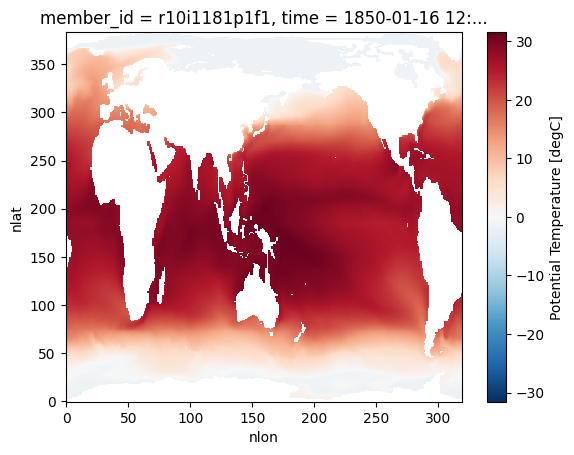

In [16]:
sst_retrieval.plot()

In [20]:
# test a regridder 

SPS_GRID = xr.open_dataset(os.path.join(DATA_DIRECTORY, 'NSIDC/sps_grid.nc'))


In [49]:
import pyproj
import matplotlib.pyplot as plt

# Define the South Polar Stereographic projection (EPSG:3031)
proj_south_pole = pyproj.Proj(proj='stere', lat_0=-90, lon_0=0, lat_ts=-71)

# Define the geographic coordinate system (EPSG:4326)
proj_geographic = pyproj.Proj(proj='latlong', datum='WGS84')

# Define the size of the grid
grid_size = 80  # 80 x 80 grid

# Define the latitude of the grid boundary
lat_boundary = -55 

# Compute the maximum radius from the South Pole in stereographic coordinates
_, max_radius = proj_south_pole(0, lat_boundary)

# Create a grid in stereographic coordinates (x, y)
x = np.linspace(-max_radius, max_radius, grid_size)
y = np.linspace(-max_radius, max_radius, grid_size)
X, Y = np.meshgrid(x, y)

# Convert the stereographic coordinates (X, Y) to geographic coordinates (latitude, longitude)
lon, lat = pyproj.transform(proj_south_pole, proj_geographic, X, Y)

/tmp/ipykernel_15330/4108644541.py:25: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lon, lat = pyproj.transform(proj_south_pole, proj_geographic, X, Y)


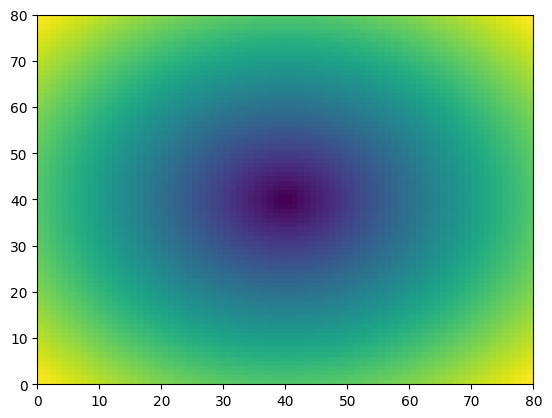

In [51]:
plt.pcolormesh(lat)